# Compare power curve from Joukowski model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from netCDF4 import Dataset

%matplotlib inline

In [2]:
# Load ruamel or pyyaml as needed
try:
    import ruamel.yaml as yaml
    print("# Loaded ruamel.yaml")
    useruamel=True
    loaderkwargs = {'Loader':yaml.RoundTripLoader}
    dumperkwargs = {'Dumper':yaml.RoundTripDumper, 'indent':4, 'default_flow_style':False} 
except:
    import yaml as yaml
    print("# Loaded yaml")
    useruamel=False
    loaderkwargs = {}
    dumperkwargs = {'default_flow_style':False }
    
if useruamel: Loader=yaml.load
else:         Loader=yaml.safe_load

# Loaded ruamel.yaml


### Load the design power curve

In [3]:
# Load performance_ccblade.dat from the web directly
# Some of this is python2 specific
import urllib2
from cStringIO import StringIO
import ssl

url='https://raw.githubusercontent.com/IEAWindTask37/IEA-15-240-RWT/master/performance/performance_ccblade.dat'

# This restores the same behavior as before.
context = ssl._create_unverified_context()
response=urllib2.urlopen(url, context=context)
f = StringIO(response.read())
designcurve=np.genfromtxt(f)
f.close()

# Show the headers
header=urllib2.urlopen(url, context=context).read().partition('\n')[0]
print('File headers:')
for ix, x in enumerate(header.split('\t')): print("%i: %s"%(ix, x))


File headers:
0: # Wind speed (m/s) 
1:  Rotor rotational speed (rpm) 
2:  Pitch angle (deg) 
3:  Rotor electrical power (W) 
4:  Rotor aerodynamic power (W) 
5:  Rotor thrust (N) 
6:  Rotor aerodynamic torque (Nm) 
7:  Blade root flapwise moment (Nm)
8:  Rotor electrical power coefficient (-) 
9:  Rotor aerodynamic power coefficient (-) 
10:  Rotor thrust coefficient (-) 
11:  Rotor aerodynamic torque coefficient


### Load the AMR-Wind power curve

In [4]:
def merge_two_dicts(x, y):
    for k, g in y.items(): x[k] = g
    return x

def loadLogFile(logfile, extradict={}):
    # Load a log file
    fp = open(logfile, 'r')
    yamldict = Loader(fp, **loaderkwargs)
    fp.close()
    returnlist=[]
    for k, g in yamldict.items():
        returnlist.append(merge_two_dicts(g, extradict))
    return returnlist

def avgoutputs(ncdat, tavg, keys, timekey='time'):
    """
    Function to average the pddat over a specific time
    """
    t = np.array(ncdat.variables[timekey])
    
    # Filter the appropriate times
    timefilter = (tavg[0]<=t)&(t<=tavg[1])
    tfilter   = t[timefilter]
    # Get the total time
    dt = np.amax(tfilter) - np.amin(tfilter)
    outdict = {}
    for key in keys:
        #f = pddat[key].values
        #print(ncdat.variables[key])
        outdict[key] = np.trapz(ncdat.variables[key][timefilter], x=tfilter, axis=0) / dt
    return outdict

def avgNCdat(ncfile, turbname, tavg, avgq):
    ncdat = Dataset(ncfile)
    return avgoutputs(ncdat[turbname], tavg, avgq)

def loadPC(logfile, extradict, firsttag, ncfile, turbname, tavg, avgq):
    PC = loadLogFile(logfile, extradict=extradict)
    # Set up the first tag
    PC[0]['tag'] = firsttag
    # Set up the out files
    for x in PC: 
        x['outfile']=x['dir']+ncfile
    # Load the power curves from the netCDF data
    for pc in PC:
        datafile = pc['outfile']
        pc.update(avgNCdat(datafile, turbname, tavg, avgq))
    return PC

In [5]:
turbname = 'T0'
tavg = [300, 360]
avgq = ['power', 'cp', 'ct', 'total_disk_force', 'angular_velocity', 'vdisk', 'vref', 'angular_velocity']

# Load each log file
PC_1 = loadPC('RunCalibration_Eps5.00_logfile.yaml', 
              {'tag':'', 'ms':'s', 'mfc':'b', 'color':'b'}, 
              'AMR-Wind Joukowski ADM', 
              '/post_processing/actuator00000/T0.nc', turbname, tavg, avgq)

## Plot the power curve and performance metrics

In [6]:
plotcurves = [PC_1] 
# For multiple runs, do
# plotcurves = PC_1 + PC_2 + etc...

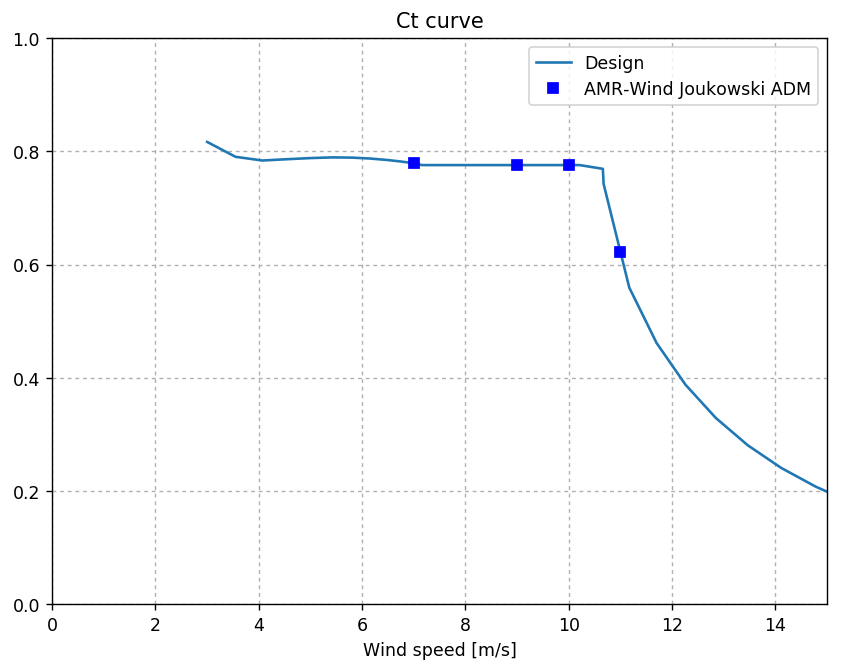

In [7]:
# Plot Ct
plt.figure(figsize=(8,6),dpi=125)

plt.plot(designcurve[:,0], designcurve[:,10], label='Design')
for pc in plotcurves:
    for p in pc:
        plt.plot(p['WS'], p['ct'], ls='', marker=p['ms'], color=p['color'], label=p['tag'])
plt.legend()
plt.title('Ct curve')
plt.xlabel('Wind speed [m/s]')
#plt.ylabel('Power [W]')
plt.xlim([0, 15])
plt.ylim([0, 1])
plt.grid(ls=':')

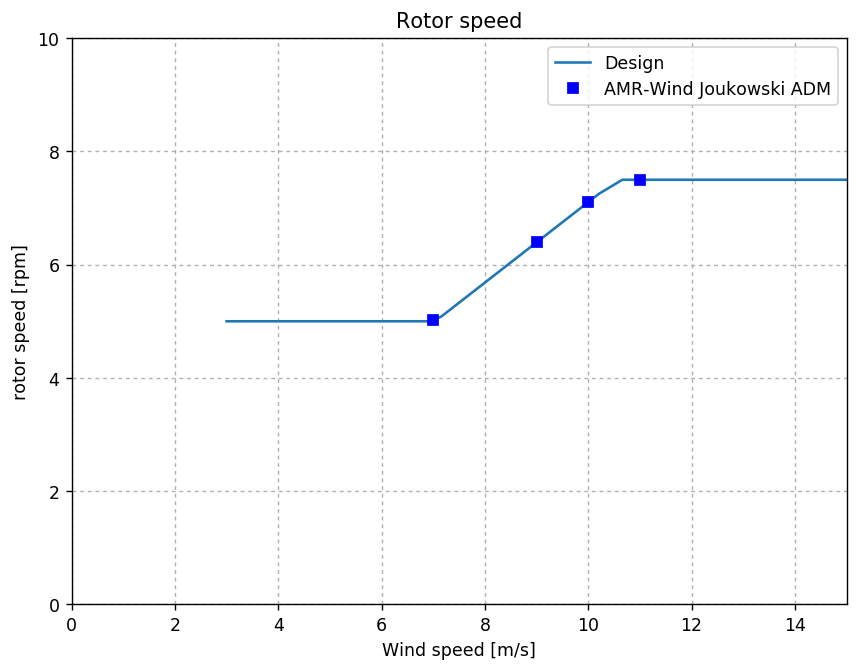

In [8]:
# Plot Ct
plt.figure(figsize=(8,6),dpi=125)

plt.plot(designcurve[:,0], designcurve[:,1], label='Design')
for pc in plotcurves:
    for p in pc:
        rpm = p['angular_velocity']*60/(2*np.pi)
        plt.plot(p['WS'], rpm, ls='', marker=p['ms'], color=p['color'], label=p['tag'])
plt.legend()
plt.title('Rotor speed')
plt.xlabel('Wind speed [m/s]')
plt.ylabel('rotor speed [rpm]')
plt.xlim([0, 15])
plt.ylim([0, 10])
plt.grid(ls=':')

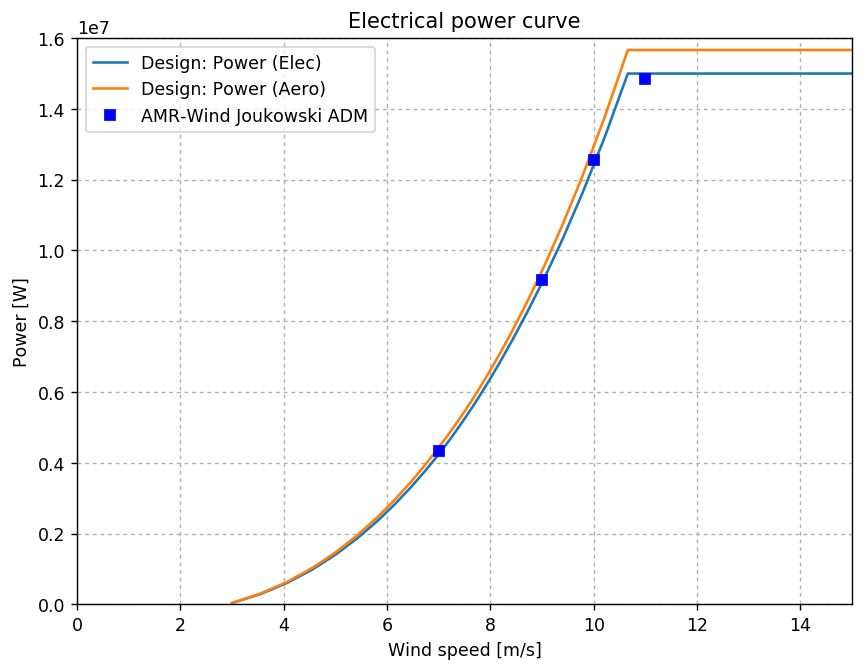

In [9]:
# Plot power
plt.figure(figsize=(8,6),dpi=125)

plt.plot(designcurve[:,0], designcurve[:,3], label='Design: Power (Elec)')
plt.plot(designcurve[:,0], designcurve[:,4], label='Design: Power (Aero)')
for pc in plotcurves:
    for p in pc:
        plt.plot(p['WS'], p['power'], ls='', marker=p['ms'], color=p['color'], label=p['tag'])
plt.legend()
plt.title('Electrical power curve')
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power [W]')
plt.xlim([0, 15])
plt.ylim([0, 16E6])
plt.grid(ls=':')

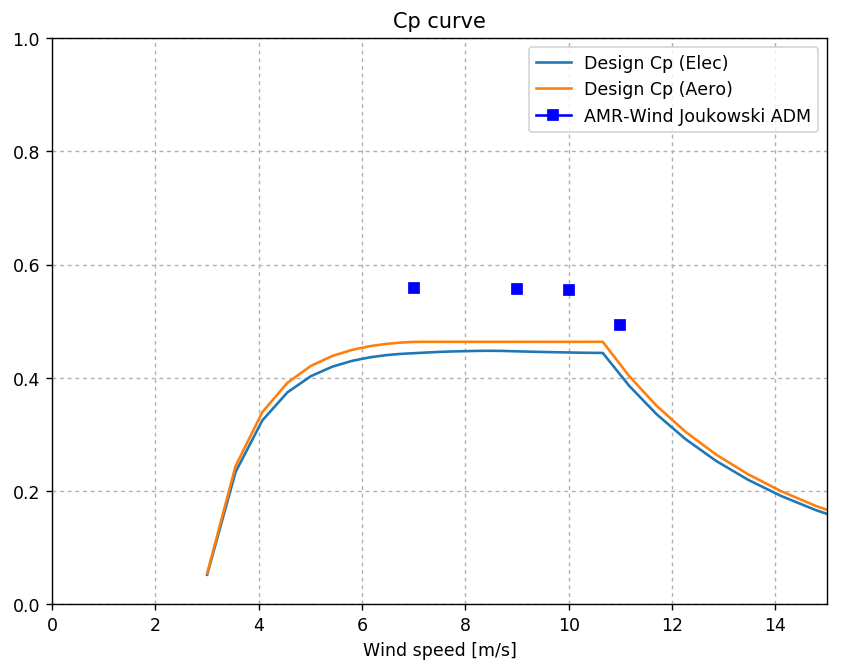

In [10]:
# Plot Cp
plt.figure(figsize=(8,6),dpi=125)

plt.plot(designcurve[:,0], designcurve[:,8], label='Design Cp (Elec)')
plt.plot(designcurve[:,0], designcurve[:,9], label='Design Cp (Aero)')

for pc in plotcurves:
    for p in pc:
        plt.plot(p['WS'], p['cp'], marker=p['ms'], color=p['color'], label=p['tag'])
        newcp = p['cp']*(p['vdisk'][0]/p['vref'][0])
        #plt.plot(p['WS'], newcp, ls='', marker=p['ms'], color='r', label=p['tag'])
plt.legend()
plt.title('Cp curve')
plt.xlabel('Wind speed [m/s]')
#plt.ylabel('Power [W]')
plt.xlim([0, 15])
plt.ylim([0, 1])
plt.grid(ls=':')

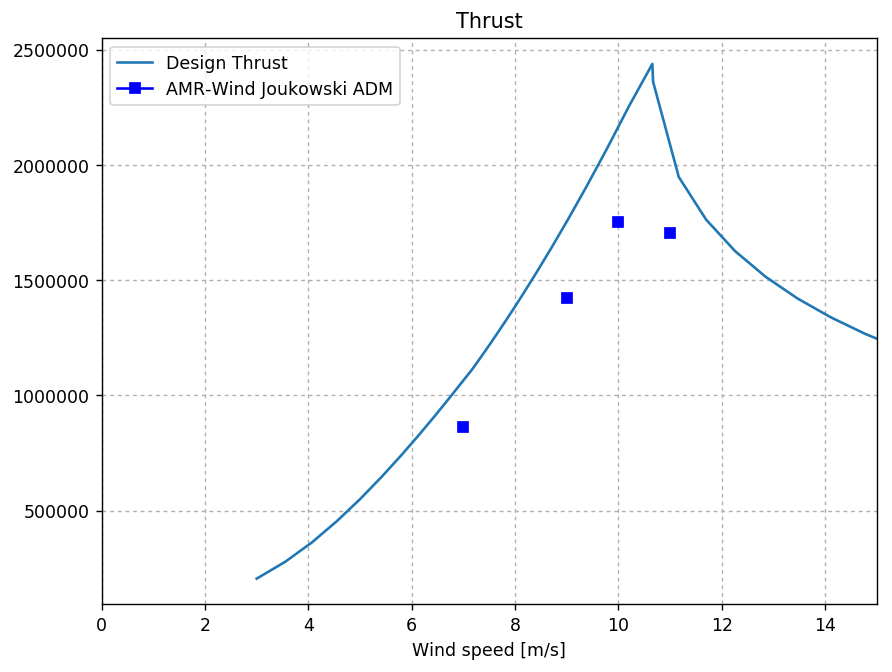

In [11]:
# Plot Cp
plt.figure(figsize=(8,6),dpi=125)

plt.plot(designcurve[:,0], designcurve[:,5], label='Design Thrust')

for pc in plotcurves:
    for p in pc:
        plt.plot(p['WS'], -p['total_disk_force'][0], marker=p['ms'], color=p['color'], label=p['tag'])
        newthrust=-p['total_disk_force'][0]*(p['vref'][0]/p['vdisk'][0])
        #plt.plot(p['WS'], newthrust, ls='', marker=p['ms'], color='r', label=p['tag'])
plt.legend()
plt.title('Thrust')
plt.xlabel('Wind speed [m/s]')
#plt.ylabel('Power [W]')
plt.xlim([0, 15])
#plt.ylim([0, 1])
plt.grid(ls=':')

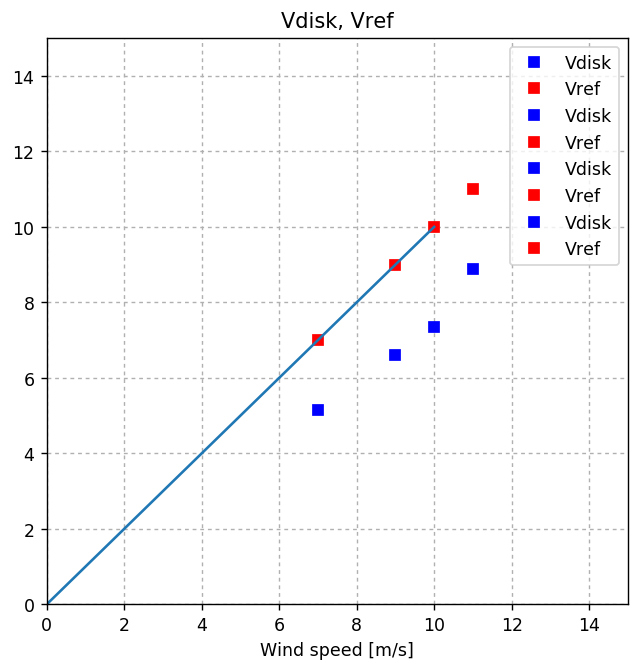

In [12]:
# Plot Cp
plt.figure(figsize=(6,6),dpi=125)

for pc in plotcurves:
    for p in pc:
        plt.plot(p['WS'], p['vdisk'][0], ls='', marker=p['ms'], color=p['color'], label='Vdisk')
        plt.plot(p['WS'], p['vref'][0], ls='', marker=p['ms'], color='r', label='Vref')
        
plt.plot([0, 10],[0, 10])
plt.legend()
plt.title('Vdisk, Vref')
plt.xlabel('Wind speed [m/s]')
#plt.ylabel('Power [W]')
plt.xlim([0, 15])
plt.ylim([0, 15])
plt.grid(ls=':')